In [15]:
import torch
from geodesic_toolbox import *
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# Create a dataset
X = torch.randn(500, 2) * 2

In [17]:
cometric = CentroidsCometric(
    centroids=X,
    cometric_centroids=IdentityCoMetric()(X),
    temperature_scale=0.6,
    K=-1,
    reg_coef=0.1,
)
bounds = get_bounds(X)
mf = get_mf_image(cometric, embeddings=X, bounds=bounds)

Computing magnification factor:   0%|          | 0/79 [00:00<?, ?batch/s]

Computing magnification factor: 100%|██████████| 79/79 [00:00<00:00, 500.95batch/s]


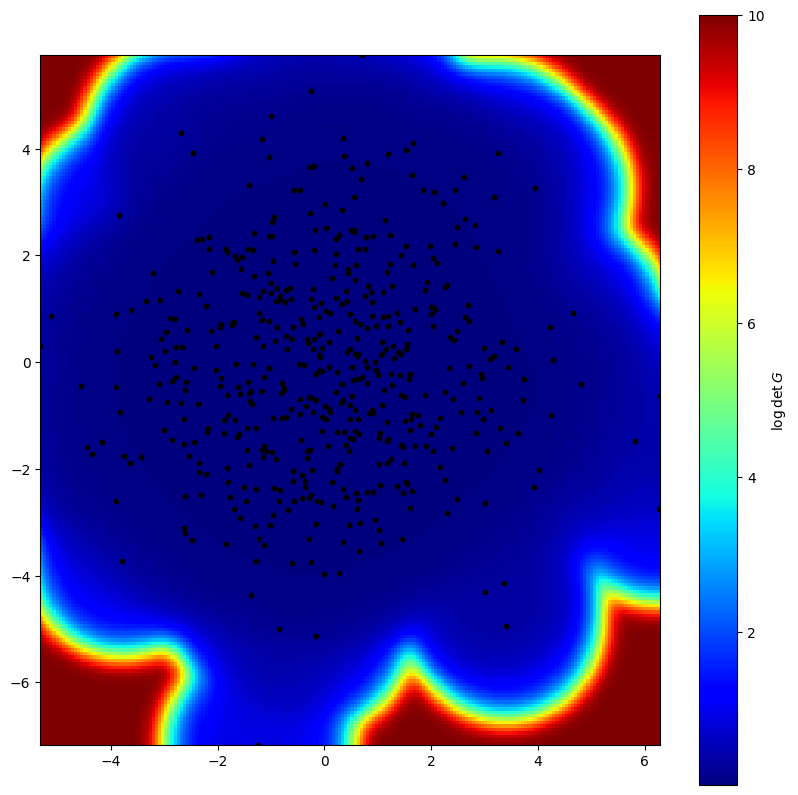

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X[:, 0], X[:, 1], c="black", s=10)
img = ax.imshow(mf.cpu().numpy(), extent=bounds, origin="lower", cmap="jet")
plt.colorbar(img, ax=ax, label=r"""$\log \det G$""")
plt.show()

In [31]:
def f(X: torch.Tensor) -> torch.Tensor:
    # B,2 -> B,2
    freq = 2.0
    x = X[:, 0]
    y = X[:, 1]
    t_x = torch.sin(x / freq) * torch.cos(y / freq)
    t_y = torch.cos(x / freq) * torch.sin(y / freq)
    res = torch.stack([t_x, t_y], dim=-1)
    return torch.norm(res, dim=-1, keepdim=True) * res


class Omega(torch.nn.Module):
    def __init__(self, f, base_cometric: CoMetric, metric_weight=1.0):
        super().__init__()
        self.f = f
        self.base_cometric = base_cometric

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        phi = self.f(X)
        # Normalize phi to have norm less than 1
        phhi_norm = self.base_cometric.cometric(X, phi)
        phi = phi / (phhi_norm.unsqueeze(-1) + 1e-5)
        return phi


omega = Omega(f, cometric)
randers = RandersMetrics(cometric, omega, beta=0.4)

In [32]:
mesh = torch.meshgrid(
    torch.linspace(bounds[0] + 1, bounds[1] - 1, 20),
    torch.linspace(bounds[2] + 1, bounds[3] - 1, 20),
    indexing="ij",
)
p_j = torch.stack([mesh[0].flatten(), mesh[1].flatten()], dim=-1)
omega_j = omega(p_j)
omega_j = omega_j / (torch.norm(omega_j, dim=-1, keepdim=True) + 1e-5) * 0.4

import plotly.figure_factory as ff
import plotly.graph_objects as go


def plot_metric_field(mf, bounds, X, p_j, omega_j, fig=None):
    if fig is None:
        fig = go.Figure()
    x_vals = torch.linspace(bounds[0], bounds[1], mf.shape[0]).cpu().numpy()
    y_vals = torch.linspace(bounds[2], bounds[3], mf.shape[1]).cpu().numpy()

    # Add the metric field image as a heatmap
    fig.add_trace(
        go.Heatmap(
            z=mf.cpu().numpy(),
            x=x_vals,
            y=y_vals,
            colorscale="Jet",
            colorbar=dict(title="Metric value"),
        )
    )
    fig.update_traces(showscale=False)

    # Add scatter plot of data points
    fig.add_trace(
        go.Scatter(
            x=X[:, 0].cpu().numpy(),
            y=X[:, 1].cpu().numpy(),
            mode="markers",
            marker=dict(size=3, color="white", opacity=0.5),
            name="Data points",
        )
    )

    # Add arrow vectors (quiver plot)
    for i in range(len(p_j)):
        fig.add_trace(
            go.Scatter(
                x=[p_j[i, 0].item(), p_j[i, 0].item() + omega_j[i, 0].item()],
                y=[p_j[i, 1].item(), p_j[i, 1].item() + omega_j[i, 1].item()],
                mode="lines",
                line=dict(color="black", width=2),
                showlegend=False,
                hoverinfo="skip",
            )
        )

    fig.update_layout(
        width=800,
        height=800,
        xaxis=dict(range=[bounds[0], bounds[1]]),
        yaxis=dict(range=[bounds[2], bounds[3]], scaleanchor="x", scaleratio=1),
    )

    return fig


fig = plot_metric_field(mf, bounds, X, p_j, omega_j)
fig.show()

In [35]:
# solver_f = SolverGraphGEORCEFinsler(finsler=randers, data=X, n_neighbors=10, pbar_georce=True)
# solver_r = SolverGraphGEORCE(cometric=cometric, data=X, n_neighbors=10, pbar_georce=True)
solver_f = GEORCEFinsler(randers, max_iter=100)
solver_r = GEORCE(cometric, max_iter=100)

In [39]:
x_0 = torch.tensor([[2.0, 0.5]])
v = torch.randn_like(x_0)
eps_list_ = torch.logspace(-3, -1, 20)

p_0_f_list = []
p_0_r_list = []
dst_f_list = []
dst_r_list = []
eps_list = []
omega_x_v_list = []

for eps in eps_list_:
    x_1 = x_0 + eps * v
    traj_0_riemann = solver_r.get_trajectories(x_0, x_1)
    traj_0_randers = solver_f.get_trajectories(x_0, x_1)
    dst_f = solver_f.compute_distance(traj_0_randers)
    dst_r = solver_r.compute_distance(traj_0_riemann)
    p_0_f = traj_0_randers[0, 1] - traj_0_randers[0, 0]
    p_0_r = traj_0_riemann[0, 1] - traj_0_riemann[0, 0]
    x_norm_f = randers.base_cometric.metric(x_0, p_0_f).sqrt()
    x_norm_r = randers.base_cometric.metric(x_0, p_0_r).sqrt()
    omega_x = randers.omega(x_0)
    omega_x_v = torch.einsum("bi,bi->b", omega_x, v)
    omega_x_v = randers.beta * omega_x_v

    p_0_f_list.append(p_0_f)
    p_0_r_list.append(p_0_r)
    dst_f_list.append(dst_f)
    dst_r_list.append(dst_r)
    omega_x_v_list.append(omega_x_v)
    eps_list.append(eps)

p_0_f_list = torch.stack(p_0_f_list).detach()
p_0_r_list = torch.stack(p_0_r_list).detach()
dst_f_list = torch.stack(dst_f_list).detach()
dst_r_list = torch.stack(dst_r_list).detach()
omega_x_v_list = torch.stack(omega_x_v_list).detach()
eps_list = torch.stack(eps_list).detach()
pred_discrepancy = dst_r_list + eps_list[:, None] * omega_x_v_list

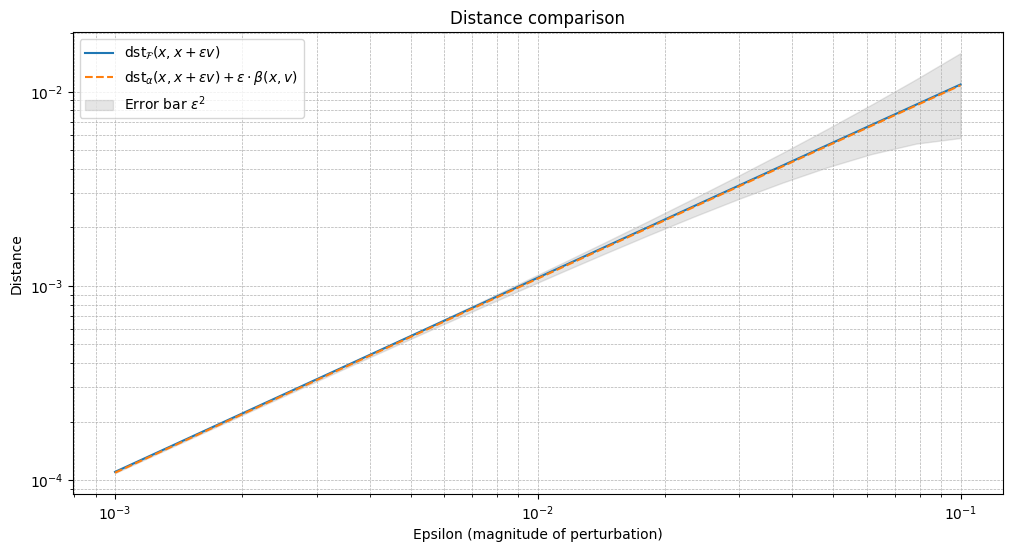

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(
    eps_list,
    dst_f_list,
    label=r"""$\text{dst}_\mathcal{F}(x,x+\epsilon v)$""",
)
ax.plot(
    eps_list,
    pred_discrepancy,
    label=r"""$\text{dst}_\alpha(x,x+\epsilon v) + \epsilon \cdot \beta(x,v)$""",
    linestyle="dashed",
)
ax.fill_between(
    eps_list,
    pred_discrepancy.squeeze() - 0.5 * eps_list**2,
    pred_discrepancy.squeeze() + 0.5 * eps_list**2,
    color="gray",
    alpha=0.2,
    label=r"""Error bar $\epsilon^2$""",
)
ax.set_xlabel("Epsilon (magnitude of perturbation)")
ax.set_ylabel("Distance")
ax.set_title("Distance comparison")
ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

In [50]:
x_0 = torch.tensor([[2.0, 0.5]])
eps_list_ = torch.logspace(-3, -1, 20)

eps_list = []
p_0_f_list, p_0_b_list = [], []
beta_f_list, beta_b_list = [], []
for v in torch.randn(1, 2):
    v = v.unsqueeze(0)
    for eps in eps_list_:
        x_1 = x_0 + eps * v
        forward_traj = solver_f.get_trajectories(x_0, x_1)
        backward_traj = solver_f.get_trajectories(x_1, x_0)
        p_0_f = forward_traj[0, 1] - forward_traj[0, 0]
        p_0_b = backward_traj[0, 1] - backward_traj[0, 0]

        omega_f = randers.omega(x_0)
        omega_f_v = torch.einsum("bi,bi->b", omega_f, p_0_f.unsqueeze(0))
        beta_f = randers.beta * omega_f_v

        omega_b = randers.omega(x_1)
        omega_b_v = torch.einsum("bi,bi->b", omega_b, p_0_b.unsqueeze(0))
        beta_b = randers.beta * omega_b_v

        eps_list.append(eps)
        p_0_f_list.append(p_0_f)
        p_0_b_list.append(p_0_b)
        beta_f_list.append(beta_f)
        beta_b_list.append(beta_b)

eps_list = torch.stack(eps_list).detach()
p_0_f_list = torch.stack(p_0_f_list).detach()
p_0_b_list = torch.stack(p_0_b_list).detach()
beta_f_list = torch.stack(beta_f_list).detach()
beta_b_list = torch.stack(beta_b_list).detach()

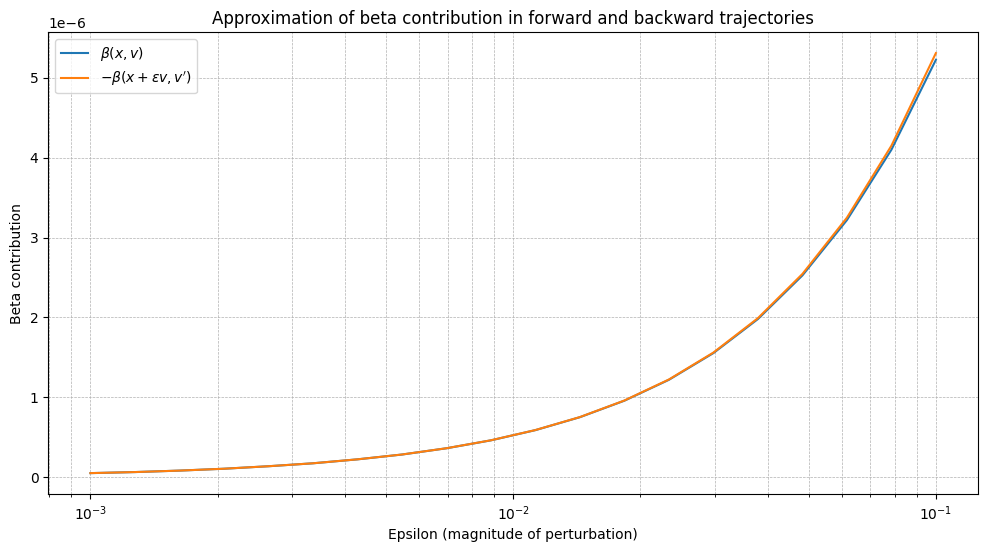

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(eps_list, beta_f_list, label=r"""$\beta(x,v)$""")
ax.plot(eps_list, -beta_b_list, label=r"""$-\beta(x+\epsilon v,v')$""")
ax.set_xlabel("Epsilon (magnitude of perturbation)")
ax.set_ylabel("Beta contribution")
ax.set_title("Approximation of beta contribution in forward and backward trajectories")
ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

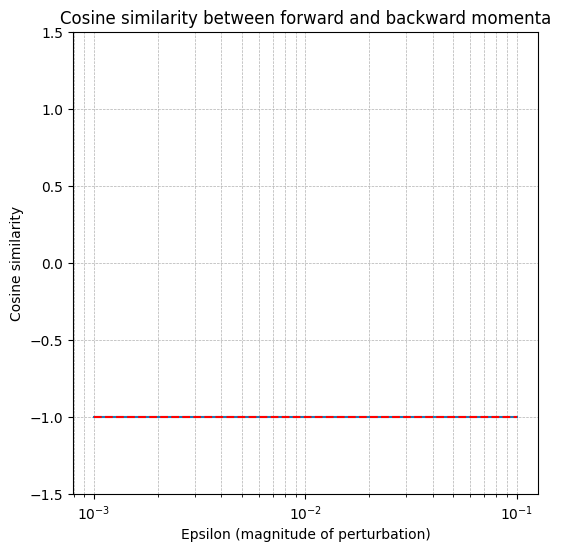

In [12]:
cosine_sim = torch.einsum("bi,bi->b", p_0_f_list, p_0_b_list) / (
    torch.norm(p_0_f_list, dim=-1) * torch.norm(p_0_b_list, dim=-1)
)
p_0_b_list[0], p_0_f_list[0], cosine_sim[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(eps_list, cosine_sim)
ax.hlines(
    -1,
    eps_list.min(),
    eps_list.max(),
    colors="red",
    linestyles="dashed",
    label="Cosine similarity = -1",
)
ax.set_ylim(-1.5, 1.5)
ax.set_xscale("log")
ax.set_xlabel("Epsilon (magnitude of perturbation)")
ax.set_ylabel("Cosine similarity")
ax.set_title("Cosine similarity between forward and backward momenta")
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()